# MULTICLASS CLASSIFICATION

In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import sys 

current_notebook_dir = os.getcwd()
base_dir_q2 = os.path.abspath(os.path.join(current_notebook_dir, "..", "Question 2"))
sys.path.append(base_dir_q2)
from Functions_22_Avino_Lombardi import gaussian_kernel, polynomial_kernel, compute_accuracy

base_dir_q3 = os.path.abspath(os.path.join(current_notebook_dir, "..", "Question 3"))
sys.path.append(base_dir_q3)

base_dir_q4 = os.path.abspath(os.path.join(current_notebook_dir))
sys.path.append(base_dir_q4)

from Functions_24_Avino_Lombardi import MulticlassSVM, _get_mvp_decision_function_scores

## Inspecting the new dataset

In [3]:
data = pd.read_csv("../dataset/ETHNICITY_CLASSIFICATION.csv")
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,gt
0,0.502792,-0.349373,-0.068018,-0.627533,0.130331,0.373488,-0.491088,0.416753,-0.046255,0.325566,...,0.374539,-0.605601,0.579226,-0.119241,0.185425,-0.255194,0.705415,-0.027761,0.581276,0
1,0.741646,-0.240194,-0.006548,-0.639129,-0.059524,0.457087,-0.500733,0.345128,-0.040395,0.334946,...,0.353851,-0.651629,0.129014,-0.034723,0.392575,-0.289928,0.380891,-0.157109,0.742231,0
2,2.836617,1.256781,2.227900,-0.603728,0.200403,1.366685,-0.666864,1.156750,-0.004516,0.767839,...,0.265453,-0.762246,-0.331476,0.051758,1.255034,-0.529064,1.412283,1.182029,3.046791,0
3,2.576996,1.784919,3.166102,-0.539903,0.108954,1.773622,-0.708488,2.679638,-0.313469,1.817676,...,0.295006,-0.866968,2.203584,-0.428082,-0.368396,-0.398743,4.043780,2.281445,5.065996,0
4,1.614504,1.103544,0.755605,-0.561434,-0.551708,0.936586,-0.575693,0.533321,0.033991,0.980126,...,0.155448,-0.825574,-0.627675,0.060466,0.815617,-0.434781,0.040881,-0.152861,2.191638,0


In [4]:
# Check basic information and class balance
print("Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nClass distribution:\n", data["gt"].value_counts())

Shape: (2500, 33)

Columns: ['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31', 'feat_32', 'gt']

Class distribution:
 gt
0    500
1    500
2    500
3    500
4    500
Name: count, dtype: int64


Given the balanced rapresentation of all five classes, we can choose three among them uniformly at random, or simply keep the first three classes

In [5]:
selected_classes = [0, 1, 2]

subset = data[data['gt'].isin(selected_classes)].copy()
# separate features from ground thruth
X = subset.drop('gt', axis=1).values
y = subset['gt'].values

## Data splitting

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1234, stratify=y) # stratify to keep class proportions balanced

# check
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

from collections import Counter
print(f"Train label distribution: {Counter(y_train)}")
print(f"Test label distribution: {Counter(y_test)}")

Shape of X_train: (1200, 32)
Shape of y_train: (1200,)
Shape of X_test: (300, 32)
Shape of y_test: (300,)
Train label distribution: Counter({np.int64(2): 400, np.int64(1): 400, np.int64(0): 400})
Test label distribution: Counter({np.int64(0): 100, np.int64(1): 100, np.int64(2): 100})


## Standardizing and Scaling

In [7]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameters Tuning and Final Model
Due to the distinct characteristics of the ETHNICITY dataset, the optimal hyperparameters identified through cross-validation for the binary classification task (Question 2), are no longer suitable for the current research objective. Therefore, we perform a new **5-fold cross-validation** procedure to tune the hyperparameters — including kernel type, kernel parameters, and classification strategy (one-vs-rest or one-vs-one) — aiming to maximize validation accuracy. The final model is then trained using the **best-performing configuration**.


In [8]:
# Hyperparameters Grid
C_values = [0.01, 0.1, 1, 10] 
strategy_values = ['ovr', 'ovo'] 
gaussian_gamma_values = [0.001, 0.01, 0.1, 1, 10]
polynomial_degree_values = [2, 3, 4]

best_score = -1
best_hyperparams = {} # Dictionary to store best C, gamma/degree, kernel type, strategy
n_splits = 5 
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 1234)

print("Starting Hyperparameter Tuning with Grid Search and 5-Fold Cross-Validation...")

for kernel_type in ['gaussian', 'polynomial']:
    print(f"\n===== TUNING FOR {kernel_type.upper()} KERNEL =====")

    for strategy in strategy_values:
        print(f"\n--- Strategy: {strategy.upper()} ---")

        if kernel_type == 'gaussian':
            for C in C_values:
                for gamma in gaussian_gamma_values:
                    print(f"  Trying C={C}, gamma={gamma}...")
                    fold_accuracies = []

                    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train)):
                        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
                        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

                        model = MulticlassSVM(C=C,
                                              kernel_func=gaussian_kernel,
                                              kernel_params={'gamma': gamma},
                                              tol=1e-3,
                                              max_iter=1000,
                                              strategy=strategy)
                        model.fit(X_fold_train, y_fold_train)
                        y_val_pred = model.predict(X_fold_val)
                        accuracy = compute_accuracy(y_val_pred, y_fold_val)
                        fold_accuracies.append(accuracy)

                    avg_accuracy = np.mean(fold_accuracies)
                    print(f"    Average CV Accuracy: {avg_accuracy:.4f}")

                    if avg_accuracy > best_score:
                        best_score = avg_accuracy
                        best_hyperparams = {
                            'kernel_type': kernel_type,
                            'C': C,
                            'gamma': gamma,
                            'strategy': strategy
                        }

        elif kernel_type == 'polynomial':
            for C in C_values:
                for p in polynomial_degree_values: # Loop over degrees
                    print(f"  Trying C={C}, degree={p}...")
                    fold_accuracies = []

                    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train)):
                        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
                        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

                        model = MulticlassSVM(C=C,
                                              kernel_func=polynomial_kernel, # Use polynomial kernel
                                              kernel_params={'p': p},      # Pass degree as 'p'
                                              tol=1e-3,
                                              max_iter=1000,
                                              strategy=strategy)
                        model.fit(X_fold_train, y_fold_train)
                        y_val_pred = model.predict(X_fold_val)
                        accuracy = compute_accuracy(y_val_pred, y_fold_val)
                        fold_accuracies.append(accuracy)

                    avg_accuracy = np.mean(fold_accuracies)
                    print(f"    Average CV Accuracy: {avg_accuracy:.4f}")

                    if avg_accuracy > best_score:
                        best_score = avg_accuracy
                        best_hyperparams = {
                            'kernel_type': kernel_type,
                            'C': C,
                            'p': p, # Store 'p' for polynomial
                            'strategy': strategy
                        }

print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best Configuration: {best_hyperparams}")
print(f"Best Average Cross-Validation Accuracy: {best_score:.4f}")



Starting Hyperparameter Tuning with Grid Search and 5-Fold Cross-Validation...

===== TUNING FOR GAUSSIAN KERNEL =====

--- Strategy: OVR ---
  Trying C=0.01, gamma=0.001...
Starting Multiclass SVM training with OVR strategy...
Training 3 One-vs-Rest (OvR) binary SVMs.
  Training OvR classifier for class '0' (1/3)...
[Converged via KKT gap] Iteration 326, m-M = 0.000485 < tol = 0.001
  Training OvR classifier for class '1' (2/3)...
[Converged via KKT gap] Iteration 326, m-M = 0.000831 < tol = 0.001
  Training OvR classifier for class '2' (3/3)...
[Converged via KKT gap] Iteration 325, m-M = 0.000244 < tol = 0.001
OvR training complete.
Total multiclass training time: 1.0548 seconds.
Starting Multiclass SVM training with OVR strategy...
Training 3 One-vs-Rest (OvR) binary SVMs.
  Training OvR classifier for class '0' (1/3)...
[Converged via KKT gap] Iteration 325, m-M = 0.000976 < tol = 0.001
  Training OvR classifier for class '1' (2/3)...
[Converged via KKT gap] Iteration 325, m-M = 0


--- Training Final Model ---
Starting Multiclass SVM training with OVR strategy...
Training 3 One-vs-Rest (OvR) binary SVMs.
  Training OvR classifier for class '0' (1/3)...
[Early Stopping] Iteration 118, no violating pair found that allows progress.
  Training OvR classifier for class '1' (2/3)...
[Early Stopping] Iteration 333, no violating pair found that allows progress.
  Training OvR classifier for class '2' (3/3)...
[Early Stopping] Iteration 481, no violating pair found that allows progress.
OvR training complete.
Total multiclass training time: 1.2885 seconds.

--- Final Evaluation on Test Set ---

FINAL REPORT


,KERNEL,C,gamma/p,TRAIN ACCURACY,TEST ACCURACY,NUMBER OF ITERATIONS,CPU TIME (s),INITIAL DUAL OBJ VALUE,FINAL DUAL OBJ VALUE
0,gaussian,1,0.1,0.9167,0.9067,932,1.1039,0.0,-163.9213



--- Generating Confusion Matrix for the Best Model ---


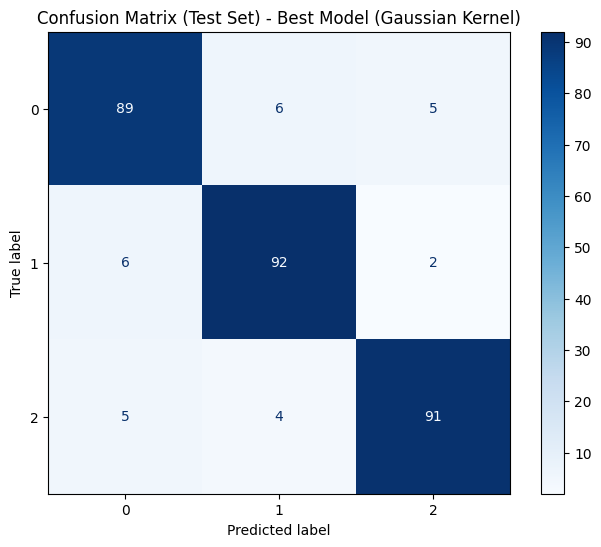

Raw Confusion Matrix:
[[89  6  5]
 [ 6 92  2]
 [ 5  4 91]]


In [9]:
#  FINAL TRAINING with the best hyperparameters on the ENTIRE training set
print("\n--- Training Final Model ---")
final_kernel_func = None
final_kernel_params = {}

if best_hyperparams['kernel_type'] == 'gaussian':
    final_kernel_func = gaussian_kernel
    final_kernel_params = {'gamma': best_hyperparams['gamma']}
elif best_hyperparams['kernel_type'] == 'polynomial':
    final_kernel_func = polynomial_kernel
    final_kernel_params = {'p': best_hyperparams['p']}

final_model = MulticlassSVM(C=best_hyperparams['C'],
                            kernel_func=final_kernel_func,
                            kernel_params=final_kernel_params,
                            tol=1e-3,
                            max_iter=1000,
                            strategy=best_hyperparams['strategy'])
final_model.fit(X_train_scaled, y_train)

# Evaluate the final model on the held-out test set
print("\n--- Final Evaluation on Test Set ---")
final_test_predictions = final_model.predict(X_test_scaled)
final_test_accuracy = compute_accuracy(final_test_predictions, y_test)

# REPORT
report_data = {}

report_data["KERNEL"] = best_hyperparams['kernel_type']
report_data["C"] = best_hyperparams['C']
if best_hyperparams['kernel_type'] == 'gaussian':
    report_data["gamma/p"] = best_hyperparams['gamma']
elif best_hyperparams['kernel_type'] == 'polynomial':
    report_data["gamma/p"] = best_hyperparams['p']

final_train_predictions = final_model.predict(X_train_scaled)
train_accuracy = compute_accuracy(final_train_predictions, y_train)
report_data["TRAIN ACCURACY"] = round(train_accuracy, 4)
report_data["TEST ACCURACY"] = round(final_test_accuracy, 4)

total_iterations = 0
total_cpu_time = 0.0
total_initial_dual_obj = 0.0
total_final_dual_obj = 0.0
num_binary_models = len(final_model.models) 

if num_binary_models > 0:
    for model_key, mvp_instance in final_model.models.items():
        total_iterations += mvp_instance.n_iter_
        total_cpu_time += mvp_instance.last_cpu_time
        total_initial_dual_obj += mvp_instance.initial_dual_obj
        total_final_dual_obj += mvp_instance.dual_objective()

    report_data["NUMBER OF ITERATIONS"] = total_iterations 
    report_data["CPU TIME (s)"] = round(total_cpu_time, 4)
    report_data["INITIAL DUAL OBJ VALUE"] = round(total_initial_dual_obj / num_binary_models, 4) # Average
    report_data["FINAL DUAL OBJ VALUE"] = round(total_final_dual_obj / num_binary_models, 4) # Average
else:
    # Fallback for empty models, though should not happen after training
    report_data["NUMBER OF ITERATIONS"] = 0
    report_data["CPU TIME (s)"] = 0.0
    report_data["INITIAL DUAL OBJ VALUE"] = 0.0
    report_data["FINAL DUAL OBJ VALUE"] = 0.0

# Create the DataFrame
multiclass_report = pd.DataFrame([report_data])

print("\nFINAL REPORT")
display(multiclass_report)

#  Generate Confusion Matrix for the best model ---
print("\n--- Generating Confusion Matrix for the Best Model ---")
y_test_flat = y_test.ravel() if y_test.ndim > 1 else y_test
final_test_predictions_flat = final_test_predictions.ravel() if final_test_predictions.ndim > 1 else final_test_predictions
class_labels = final_model.classes_

cm = confusion_matrix(y_test_flat, final_test_predictions_flat, labels=class_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title(f'Confusion Matrix (Test Set) - Best Model ({best_hyperparams["kernel_type"].capitalize()} Kernel)')
plt.show()

print("Raw Confusion Matrix:")
print(cm)